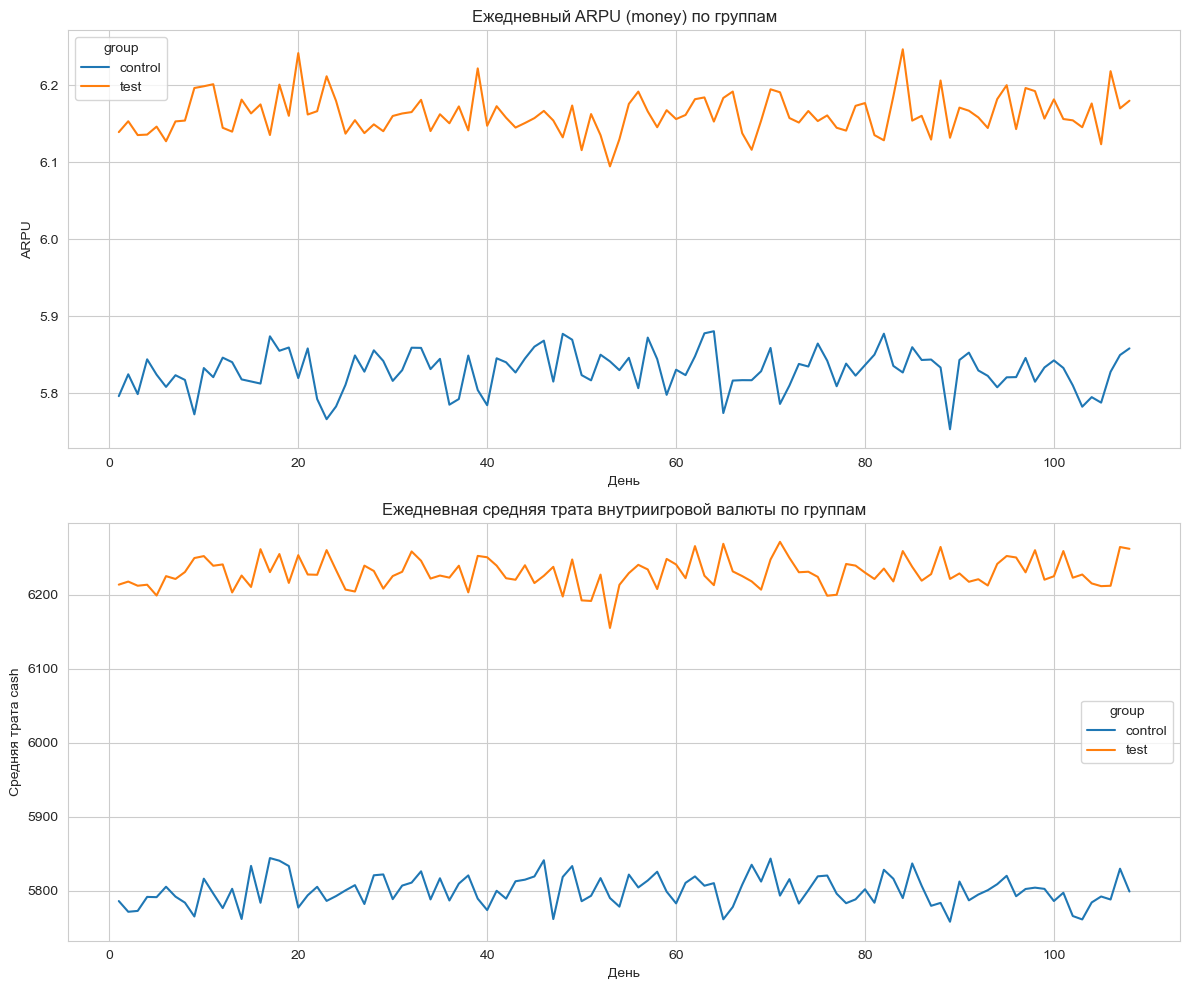

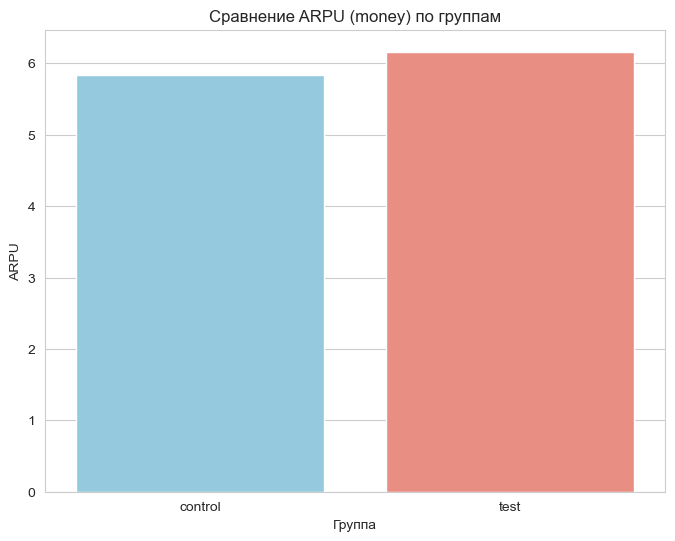


--- Итоговый анализ ---
Количество известных читеров: 353
Количество потенциальных читеров: 343
Всего удалено читеров: 696
Количество пользователей в очищенном датасете: 1079304

Метрики:
ARPU (money): 
group
control    5.829467
test       6.162276
Name: money, dtype: float64

ARPPU (money): 
group
control    5.831109
test       6.163144
Name: money, dtype: float64

Средняя трата внутриигровой валюты (cash): 
group
control    5800.732974
test       6229.596319
Name: cash, dtype: float64

ARPU по платформам:
group    platform
control  PC          5.646170
         PS4         5.737647
         XBox        6.103521
test     PC          6.269046
         PS4         6.084883
         XBox        6.132766
Name: money, dtype: float64

Доверительные интервалы ARPU (money):
Контрольная группа: [5.82, 5.83]
Тестовая группа: [6.16, 6.17]


In [3]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля графиков для лучшей читаемости
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Загрузка и очистка данных от дубликатов
df_abgroup = pd.read_csv('ABgroup.csv').drop_duplicates()
df_cash = pd.read_csv('Cash.csv').drop_duplicates()
df_cheaters = pd.read_csv('Cheaters.csv').drop_duplicates()
df_money = pd.read_csv('Money.csv').drop_duplicates()
df_platforms = pd.read_csv('Platforms.csv').drop_duplicates()

# 2. Агрегация и объединение данных
df_cash_agg = df_cash.groupby('user_id')['cash'].sum().reset_index()
df_money_agg = df_money.groupby('user_id')['money'].sum().reset_index()
df_final = df_abgroup.merge(df_platforms, on='user_id', how='left')
df_final = df_final.merge(df_cash_agg, on='user_id', how='left')
df_final = df_final.merge(df_money_agg, on='user_id', how='left')
df_final = df_final.merge(df_cheaters, on='user_id', how='left')

# Заполнение пропусков
df_final['cheaters'] = df_final['cheaters'].fillna(0)
df_final['cash'] = df_final['cash'].fillna(0)
df_final['money'] = df_final['money'].fillna(0)

# 3. Выявление и удаление читеров
known_cheaters = df_final[df_final['cheaters'] == 1]['user_id'].tolist()
df_pc_users = df_final[df_final['platform'] == 'PC'].copy()
df_pc_users['cash_zscore'] = st.zscore(df_pc_users['cash'])
potential_cheaters_ids = df_pc_users[
    (df_pc_users['cheaters'] == 0) &
    (df_pc_users['money'] == 0) &
    (df_pc_users['cash_zscore'] > 3)
]['user_id'].tolist()
all_cheaters_to_remove = list(set(known_cheaters) | set(potential_cheaters_ids))
df_clean = df_final[~df_final['user_id'].isin(all_cheaters_to_remove)].copy()

# 4. Расчет метрик
arpu = df_clean.groupby('group')['money'].mean()
paying_users = df_clean[df_clean['money'] > 0]
arppu = paying_users.groupby('group')['money'].mean()
avg_cash_spent = df_clean.groupby('group')['cash'].mean()
arpu_by_platform = df_clean.groupby(['group', 'platform'])['money'].mean()

# Функция для расчета доверительного интервала
def get_ci(data, confidence=0.95):
    mean = data.mean()
    se = st.sem(data)
    h = se * st.t.ppf((1 + confidence) / 2, len(data) - 1)
    return mean, mean - h, mean + h

ci_control = get_ci(df_clean[df_clean['group'] == 'control']['money'])
ci_test = get_ci(df_clean[df_clean['group'] == 'test']['money'])

# 5. Визуализация
total_rows = len(df_clean)
days_in_test = total_rows // 10000
remainder = total_rows % 10000
day_column = np.tile(np.arange(1, days_in_test + 1), 10000)
day_column = np.append(day_column, np.repeat(days_in_test + 1, remainder))[:total_rows]
df_clean['day'] = day_column

df_daily = df_clean.groupby(['day', 'group']).agg(
    arpu=('money', 'mean'),
    avg_cash=('cash', 'mean')
).reset_index()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
sns.lineplot(data=df_daily, x='day', y='arpu', hue='group', ax=axes[0])
axes[0].set_title('Ежедневный ARPU (money) по группам')
axes[0].set_ylabel('ARPU')
axes[0].set_xlabel('День')

sns.lineplot(data=df_daily, x='day', y='avg_cash', hue='group', ax=axes[1])
axes[1].set_title('Ежедневная средняя трата внутриигровой валюты по группам')
axes[1].set_ylabel('Средняя трата cash')
axes[1].set_xlabel('День')
plt.tight_layout()
plt.show()

# Визуализация сравнения ARPU по группам с исправлением FutureWarning
plt.figure(figsize=(8, 6))
sns.barplot(x=arpu.index, y=arpu.values, hue=arpu.index, palette=['skyblue', 'salmon'], legend=False)
plt.title('Сравнение ARPU (money) по группам')
plt.xlabel('Группа')
plt.ylabel('ARPU')
plt.show()

# --- Итоговый анализ ---
print("\n--- Итоговый анализ ---")
print(f"Количество известных читеров: {len(known_cheaters)}")
print(f"Количество потенциальных читеров: {len(potential_cheaters_ids)}")
print(f"Всего удалено читеров: {len(all_cheaters_to_remove)}")
print(f"Количество пользователей в очищенном датасете: {len(df_clean)}")
print("\nМетрики:")
print(f"ARPU (money): \n{arpu}")
print(f"\nARPPU (money): \n{arppu}")
print(f"\nСредняя трата внутриигровой валюты (cash): \n{avg_cash_spent}")
print("\nARPU по платформам:")
print(arpu_by_platform)
print("\nДоверительные интервалы ARPU (money):")
print(f"Контрольная группа: [{ci_control[1]:.2f}, {ci_control[2]:.2f}]")
print(f"Тестовая группа: [{ci_test[1]:.2f}, {ci_test[2]:.2f}]")